In [7]:
import qiskit
from qoop.core import state, metric, ansatz
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.evolution.environment_synthesis import MetadataSynthesis
from qoop.evolution.environment import EEnvironment
from qoop.evolution import crossover, divider, normalizer, generator
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
import pennylane as qml
from sync import cost as cost_func
from sync import circuit, constant
import pennylane.numpy as nps
import pennylane as qml
%load_ext autoreload
%autoreload 2
def fitness_synthesis(qc_qiskit: qiskit.QuantumCircuit):
    dev = qml.device("default.qubit")
    qfunc = qml.from_qiskit(qc_qiskit, measurements=qml.expval(qml.Z(0)))
    qc = qml.QNode(qfunc, dev)

    thetas = nps.random.uniform(0, 2*nps.pi, len(qc_qiskit.parameters))
    def cost(thetas):
        matrix = qml.matrix(qc, wire_order=list(range(qc_qiskit.num_qubits)))(thetas)
        return cost_func.c_hst(matrix, target)

    steps = 5
    costs = []
    opt = qml.AdamOptimizer(stepsize = 0.01)
    for n in range(steps):
        thetas, prev_cost = opt.step_and_cost(cost, thetas)
        if prev_cost < constant.error:
            print("Achieved error threshold at step", n)
            break
        costs.append(prev_cost)
    return 1-costs[-1].numpy()

env_metadata = MetadataSynthesis(
        num_qubits = 3, # As its name
        num_cnot = 10, # Number of CNOT gate you want
        depth = 10, # Ansatz depth you want
        num_circuit = 8, # Number of ansatz per generation
        num_generation = 10, # Number of generation/iteration for GA 
        prob_mutate = 0.01 # Mutation probability, usually as small as 0.01 (1%)
)

target = UnitaryGate(random_unitary(2**env_metadata.num_qubits))
env = EEnvironment(
    metadata = env_metadata,
    fitness_func = fitness_synthesis,
    generator_func = generator.by_num_cnot,
    crossover_func = crossover.onepoint(
        divider.by_num_cnot(int(env_metadata.num_cnot/2)), 
        normalizer.by_num_cnot(env_metadata.num_cnot))
).evol()

Initialize list of circuit ...
Start evol progress ...
Running at generation 1


Process SpawnProcess-1:
Traceback (most recent call last):
Process SpawnProcess-2:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'fitness_synthesis' on <module '__main__' (built-in)>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

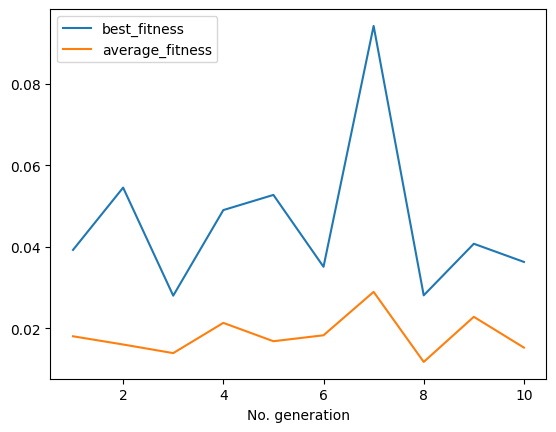

In [15]:
env.plot()

In [2]:
from qiskit import QuantumCircuit
from qiskit import qpy

with open('./3qubits_fitness_synthesis_2024-12-04/best_circuit.qpy', 'rb') as f:
	qc_qiskit = qpy.load(f)[0]

dev = qml.device("default.qubit")
qfunc = qml.from_qiskit(qc_qiskit, measurements=qml.expval(qml.Z(0)))
qc = qml.QNode(qfunc, dev)

thetas = nps.random.uniform(0, 2*nps.pi, len(qc_qiskit.parameters))
def cost(thetas):
	matrix = qml.matrix(qc, wire_order=list(range(qc_qiskit.num_qubits)))(thetas)
	return cost_func.c_hst(matrix, target)

steps = 1000
costs = []
opt = qml.AdamOptimizer(stepsize = 0.01)
for n in range(steps):
	thetas, prev_cost = opt.step_and_cost(cost, thetas)
	if prev_cost < constant.error:
		print("Achieved error threshold at step", n)
		break
	costs.append(prev_cost)

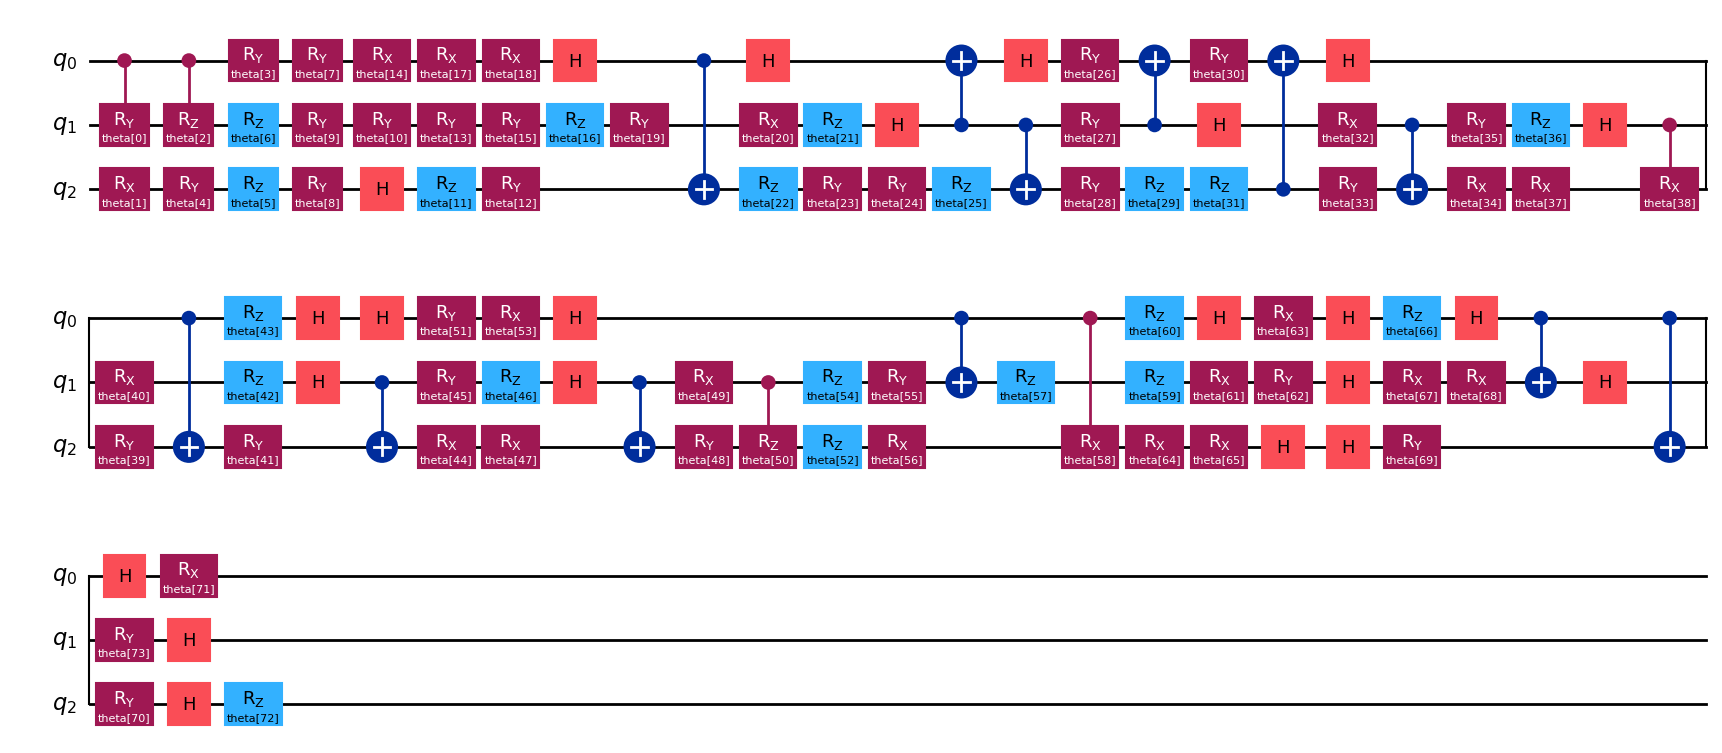

In [5]:
qc_qiskit.draw('mpl')

0.07630793969998895


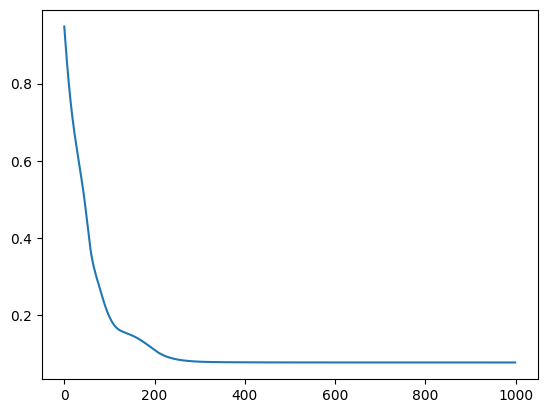

In [4]:
import matplotlib.pyplot as plt
print(min(costs))
plt.plot(costs)

18


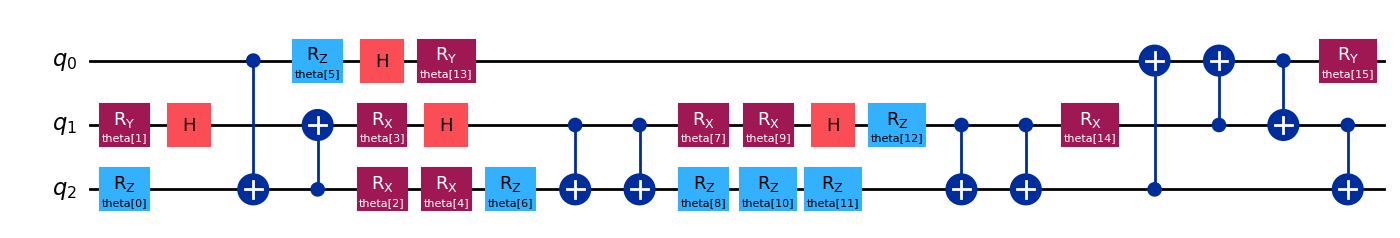

In [5]:

from qoop.evolution.environment_synthesis import MetadataSynthesis
env_metadata = MetadataSynthesis(
        num_qubits = 3, # As its name
        num_cnot = 10, # Number of CNOT gate you want
        depth = 10, # Ansatz depth you want
        num_circuit = 8, # Number of ansatz per generation
        num_generation = 10, # Number of generation/iteration for GA 
        prob_mutate = 0.01 # Mutation probability, usually as small as 0.01 (1%)
)

from qoop.evolution.generator import by_num_cnot

qc = by_num_cnot(env_metadata)
print(qc.depth())
qc.draw('mpl')

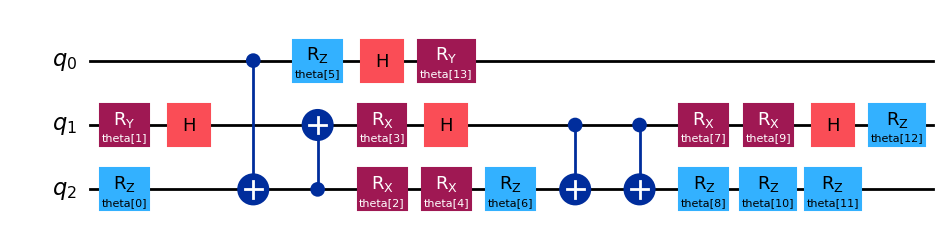

In [6]:

from qoop.evolution import crossover, divider, normalizer, generator
qc_cut = (normalizer.by_num_cnot(4))(qc)
qc_cut.draw('mpl')

In [ ]:
qc